**Capstone Project**

**Business Objective**

The business goal of this task is to attempt to predict whether a student will graduate or drop out of college based on student data, including demographic data, socioeconomic data, and prior academic performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score


In [3]:
# Load in the dataset
students = pd.read_csv('Data/dataset.csv')

In [5]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

This dataset will be pretty easy to work with in that almost all of the fields are numeric (int or float) values.

Some of these fields are actual numeric values (like GDP for example) whereas many of them are categories that are numerically encoded.

In [7]:
print("Percent of Null Values by Column")
print(students.isnull().mean()*100)

Percent of Null Values by Column
Marital status                                    0.0
Application mode                                  0.0
Application order                                 0.0
Course                                            0.0
Daytime/evening attendance                        0.0
Previous qualification                            0.0
Nacionality                                       0.0
Mother's qualification                            0.0
Father's qualification                            0.0
Mother's occupation                               0.0
Father's occupation                               0.0
Displaced                                         0.0
Educational special needs                         0.0
Debtor                                            0.0
Tuition fees up to date                           0.0
Gender                                            0.0
Scholarship holder                                0.0
Age at enrollment                                

This is great news - the dataset does not contain any null values that need to be cleaned.

In [9]:
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [11]:
students["Target"].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

It seems like the target column has 3 possible values: Graduate, Dropout, and Enrolled.  

Since the goal of my Capstone project is to attempt to predict whether students will graduate or drop out, I am gong to eliminate the "Enrolled" rows in the dataset. For the purposes of my study, these students are in an indeterminate state - they are currently enrolled but we don't know whether they will ultimately graduate or drop out.

In [13]:
students.drop(students[students["Target"] == "Enrolled"].index, inplace = True)

In [15]:
students["Target"].value_counts(normalize = True)

Target
Graduate    0.60854
Dropout     0.39146
Name: proportion, dtype: float64

The target data is somewhat imbalanced (61% graduate vs 39% dropout) 

**Analyzing & Visualizing the data**


In [17]:
# Let's look at some basic stats on the numeric columns
students.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,...,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,1.184298,6.810193,1.750138,9.935537,0.887603,2.552617,1.242424,12.558678,16.663636,7.212948,...,0.128926,0.581818,6.296419,7.763085,4.518457,10.036155,0.142149,11.630358,1.231598,-0.009256
std,0.613009,5.253618,1.333831,4.340715,0.315897,3.952440,1.700394,9.006183,10.993025,3.707343,...,0.679111,2.022688,2.263020,3.964163,3.162376,5.481742,0.747670,2.667652,1.384911,2.259986
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.517857,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,8.000000,1.000000,11.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.333333,0.000000,11.100000,1.400000,0.320000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.500000,0.000000,13.900000,2.600000,1.790000
max,6.000000,18.000000,6.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


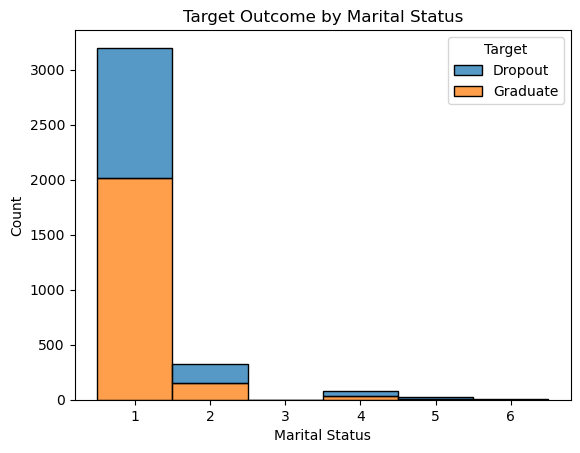

In [19]:
# Let's look at how some of the features are distributed by the target variable.
sns.histplot(data=students, x='Marital status', hue='Target', multiple='stack', discrete=True)
plt.title('Target Outcome by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()

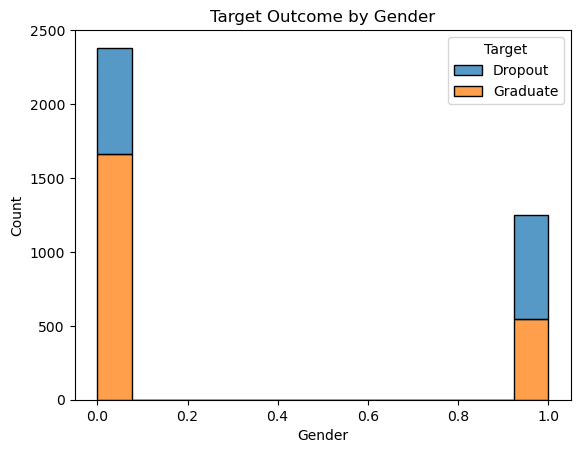

In [21]:
sns.histplot(data=students, x='Gender', hue='Target', multiple='stack')
plt.title('Target Outcome by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

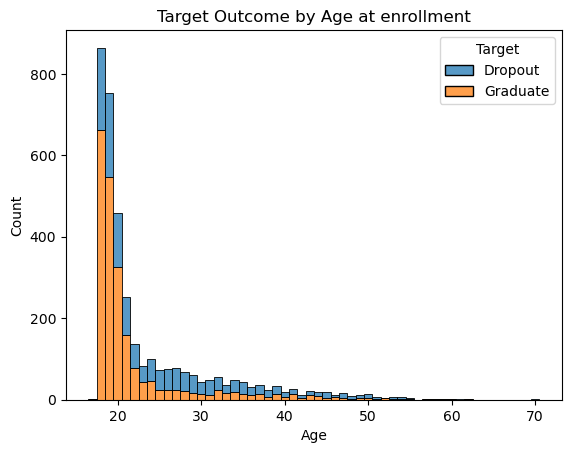

In [23]:
sns.histplot(data=students, x='Age at enrollment', hue='Target', multiple='stack', discrete = True)
plt.title('Target Outcome by Age at enrollment')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Although the majority of the students are 18-22 as might be expected, it seems like a higher percentage of older students drop out as shown in this graph.

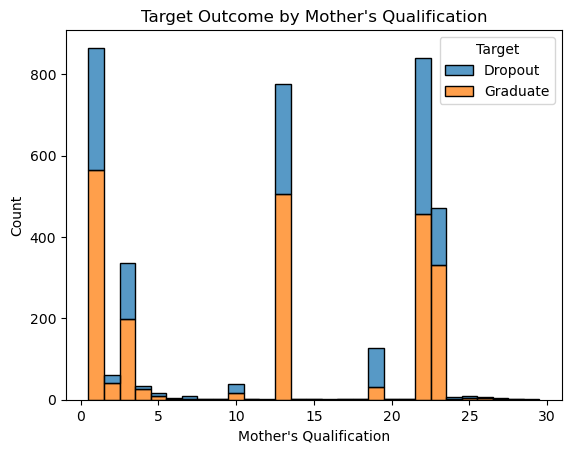

In [25]:
sns.histplot(data=students, x="Mother's qualification", hue='Target', multiple='stack', discrete=True)
plt.title("Target Outcome by Mother's Qualification")
plt.xlabel("Mother's Qualification")
plt.ylabel('Count')
plt.show()

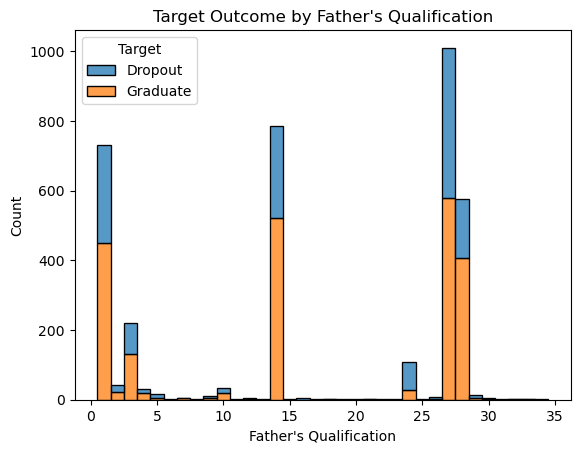

In [27]:
sns.histplot(data=students, x="Father's qualification", hue='Target', multiple='stack', discrete=True)
plt.title("Target Outcome by Father's Qualification")
plt.xlabel("Father's Qualification")
plt.ylabel('Count')
plt.show()

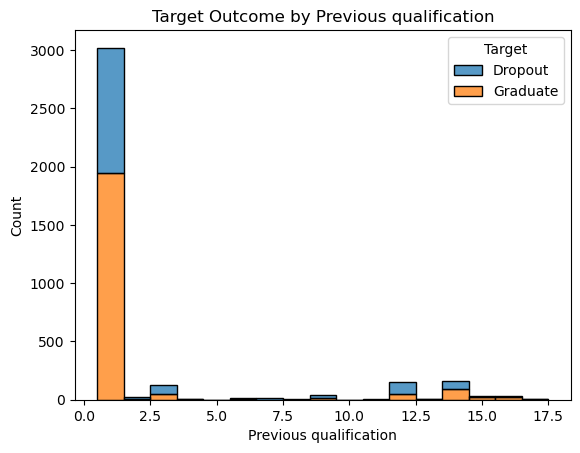

In [29]:
sns.histplot(data=students, x="Previous qualification", hue='Target', multiple='stack', discrete = True)
plt.title("Target Outcome by Previous qualification")
plt.xlabel('Previous qualification')
plt.ylabel('Count')
plt.show()

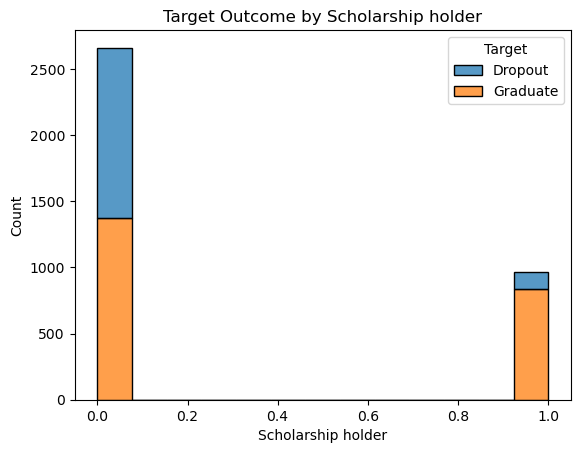

In [31]:
sns.histplot(data=students, x="Scholarship holder", hue='Target', multiple='stack')
plt.title("Target Outcome by Scholarship holder")
plt.xlabel('Scholarship holder')
plt.ylabel('Count')
plt.show()

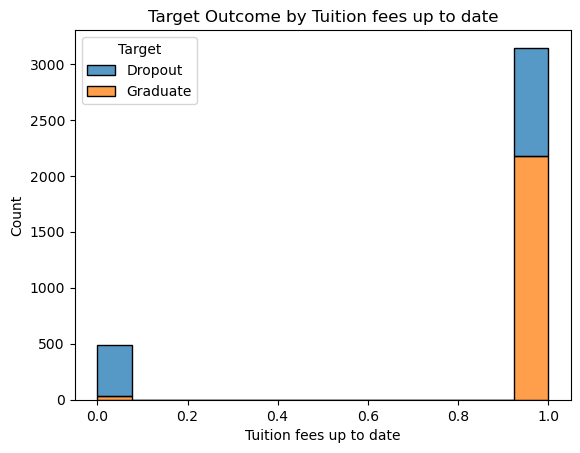

In [33]:
sns.histplot(data=students, x="Tuition fees up to date", hue='Target', multiple='stack')
plt.title("Target Outcome by Tuition fees up to date")
plt.xlabel('Tuition fees up to date')
plt.ylabel('Count')
plt.show()

Tuition fees not being up to date seems to be a big factor too.  A very large percentage of the students with fees not up to date seem to drop out.

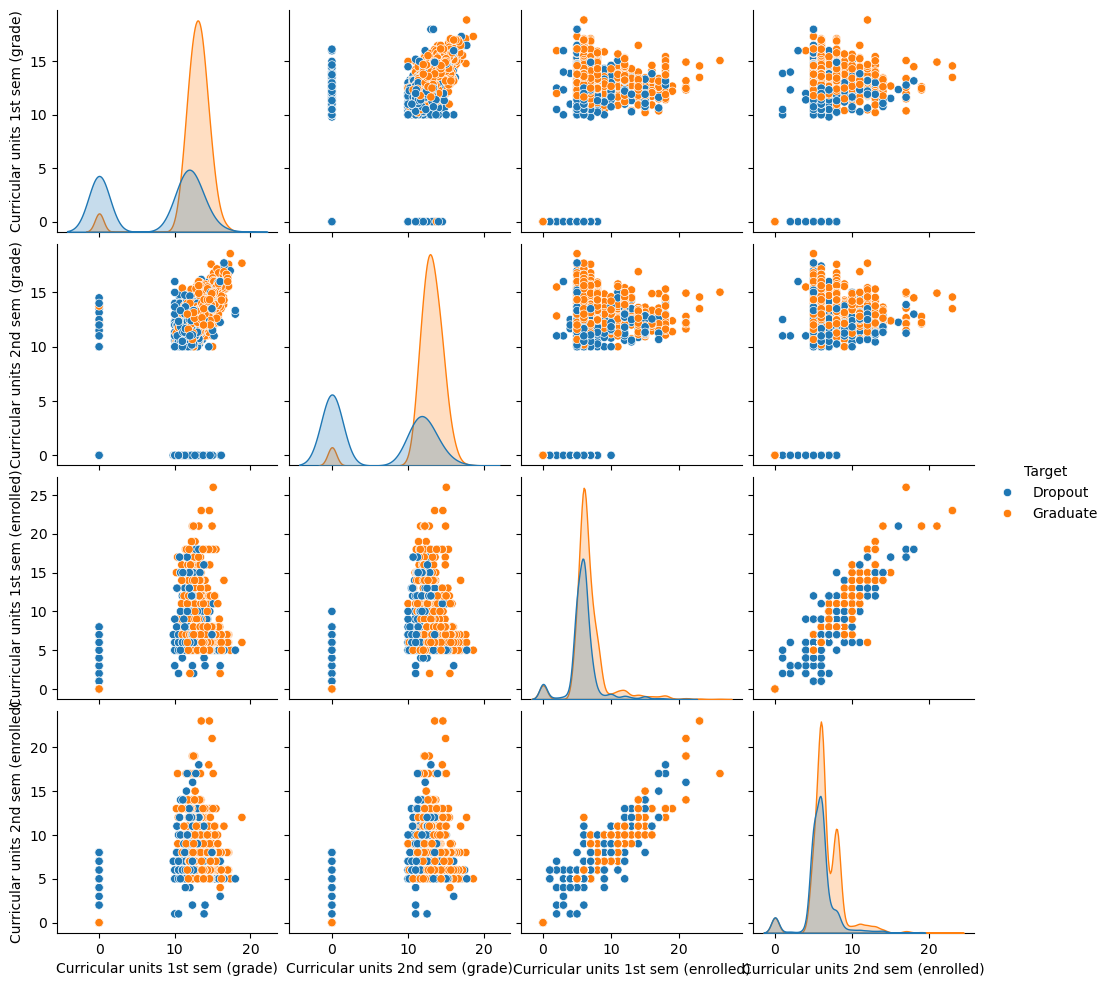

In [37]:
# Seems like a lot of the students who drop out have first and/or second semester grades of 0. 
# Wondering what this means - did they not take classes?
data_columns = ['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 
                'Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)', 'Target']
sns.pairplot(students[data_columns], hue = 'Target')

In [39]:
# I also want to examine the correlations between the numeric features.
corr = students.corr(numeric_only = True).round(2)
corr

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
Marital status,1.00,0.24,-0.13,0.00,-0.27,0.13,-0.02,0.18,0.12,0.07,...,0.04,0.07,0.04,0.03,-0.06,-0.08,0.03,-0.02,0.01,-0.03
Application mode,0.24,1.00,-0.25,-0.08,-0.28,0.43,-0.01,0.10,0.09,0.01,...,0.05,0.24,0.13,0.16,-0.08,-0.12,0.05,0.08,-0.03,-0.01
Application order,-0.13,-0.25,1.00,0.12,0.17,-0.20,-0.03,-0.06,-0.05,-0.04,...,-0.04,-0.13,0.03,-0.04,0.07,0.06,-0.03,-0.10,-0.00,0.03
Course,0.00,-0.08,0.12,1.00,-0.03,-0.16,0.00,0.04,0.03,0.02,...,-0.06,-0.12,0.18,0.06,0.10,0.17,-0.02,-0.05,0.04,0.01
Daytime/evening attendance,-0.27,-0.28,0.17,-0.03,1.00,-0.12,0.03,-0.18,-0.13,-0.04,...,0.04,-0.11,0.01,0.01,0.05,0.06,-0.01,0.07,-0.02,0.01
Previous qualification,0.13,0.43,-0.20,-0.16,-0.12,1.00,-0.04,0.01,0.02,0.00,...,0.04,0.14,0.05,0.08,-0.05,-0.05,0.05,0.09,-0.06,0.06
Nacionality,-0.02,-0.01,-0.03,0.00,0.03,-0.04,1.00,-0.03,-0.08,0.02,...,0.01,0.00,-0.03,-0.03,-0.02,-0.01,-0.01,-0.00,-0.01,0.03
Mother's qualification,0.18,0.10,-0.06,0.04,-0.18,0.01,-0.03,1.00,0.53,0.31,...,0.01,0.04,0.03,0.03,-0.02,-0.03,0.03,-0.11,0.06,-0.07
Father's qualification,0.12,0.09,-0.05,0.03,-0.13,0.02,-0.08,0.53,1.00,0.22,...,-0.01,0.05,0.03,0.01,0.00,-0.01,0.00,-0.07,0.06,-0.06
Mother's occupation,0.07,0.01,-0.04,0.02,-0.04,0.00,0.02,0.31,0.22,1.00,...,-0.01,-0.00,0.00,-0.01,0.03,0.04,-0.00,0.01,0.03,0.07


In [43]:
#Load in course description mapping
courses_df = pd.read_csv('Data/Course_Descriptions.csv')

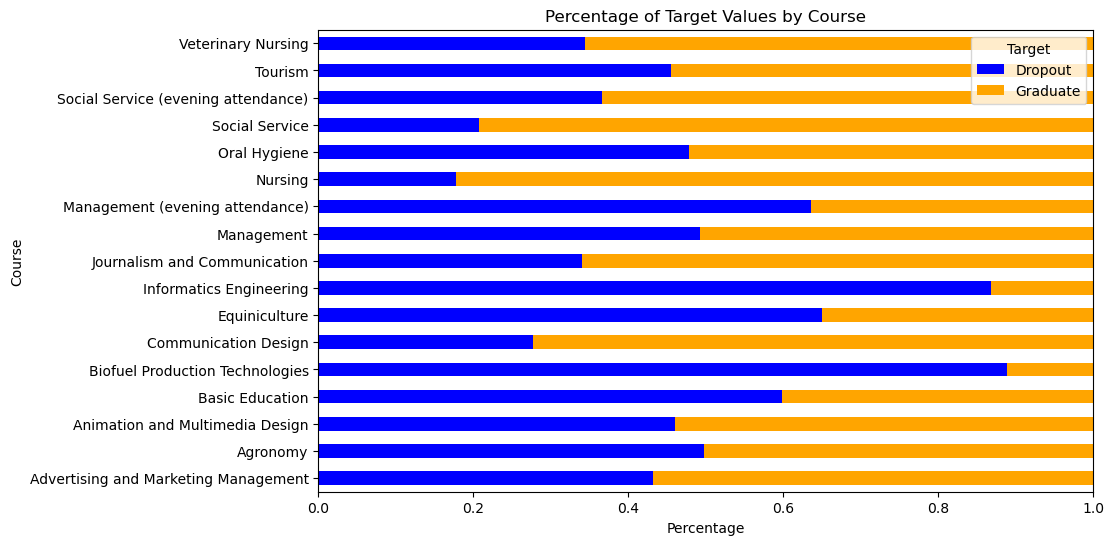

In [45]:
#merge the course descriptions so the bar graph below shows the actual courses of study instead of the numeric codes.
courses_merge = students[["Course", "Target"]].merge(courses_df, on="Course")

target_percentage = courses_merge.groupby('Description')['Target'].value_counts(normalize=True).unstack(fill_value=0)

ax = target_percentage.plot(kind='barh', stacked=True, color=['blue', 'orange'], figsize=(10, 6))

# Customize the plot
plt.title('Percentage of Target Values by Course')
plt.xlabel('Percentage')
plt.ylabel('Course')
plt.xlim(0, 1)
plt.show()

**Preparing to Build Models**

In [47]:
#Add a graduated column
# 1 = Graduate, 0 = Dropout
# Will use this column as the Target for prediction models
students["Graduated"] = students['Target'].map({'Graduate': 1, 'Dropout': 0})

In [49]:
# Now I'm going to start getting the data ready for my analysis
X = students.drop(columns = ['Target','Graduated'], axis = 1)
y = students["Graduated"]

In [51]:
# now create the test & training data, keeping 30% for testing
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Creating a results table so that I can track all of the models and compare them at the end.
# The columns will be: model, train_time, train_accuracy, test_accuracy, train_precision, and test_precision
results = []

**Evaluating Models**

I plan to look at accuracy of the various models, but I also plan to measure their precision.
Precision is important here because we want to minimize the number of false positives.  
These are students who wil drop out but we incorrectly predict they will graduate.  
It is important to minimize this group because if we can find a way to better support students who will drop out, then we will not end up helping the students in the false positive group because we won't realize that they will end up dropping out. 

Accuracy on Training Data:  0.606
Accuracy on Test Data:  0.618


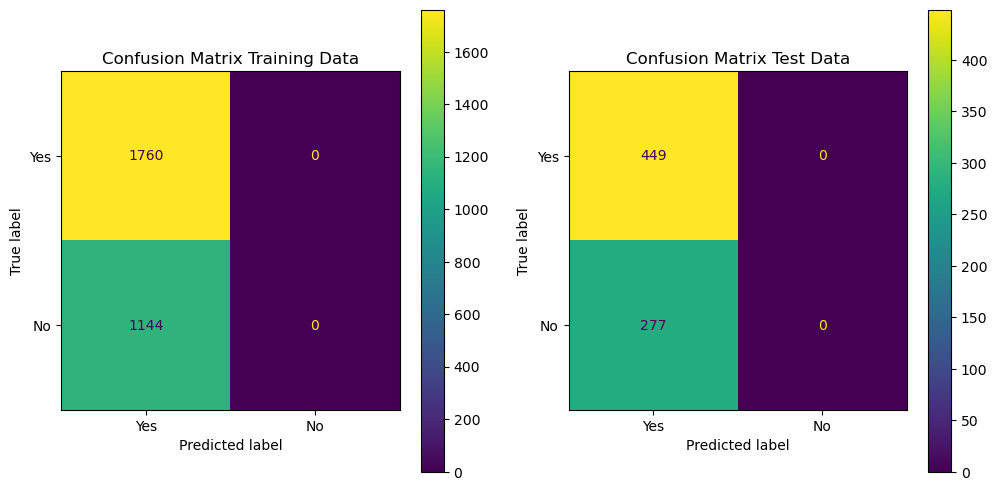

In [55]:
# Create a baseline model that predicts the most frequent class
# In the case of our data, this model will just predict 0/no all the time
start_time = time.time()
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
end_time = time.time()
baseline_model_time = end_time - start_time

y_pred_train = baseline.predict(X_train)
y_pred_test = baseline.predict(X_test)
# We can view the overall accuracy score of this baseline model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on Training Data: ", round(acc_train,3))
print("Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix
baseline_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=baseline_train_cm, display_labels = ['Yes' ,'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

baseline_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=baseline_test_cm, display_labels = ['Yes' ,'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

prec_train = precision_score(y_train, y_pred_train)
prec_test = precision_score(y_test, y_pred_test)

#store metrics for this model
results.append(["baseline", baseline_model_time, acc_train, acc_test, prec_train, prec_test])

**Basic Logistic Regression Model**

In [57]:
# before building other models, I am going to scale the data.
# This will be important for many of the classification models
scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [59]:
# Here is a basic logistic regression model.
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
end_time = time.time()
lr_model_time = end_time - start_time

print("The Logistic Regression model took ", round(lr_model_time, 4))

The Logistic Regression model took  0.0397


Logistic Regression Accuracy on Training Data:  0.915
Logistic Regression Accuracy on Test Data:  0.908


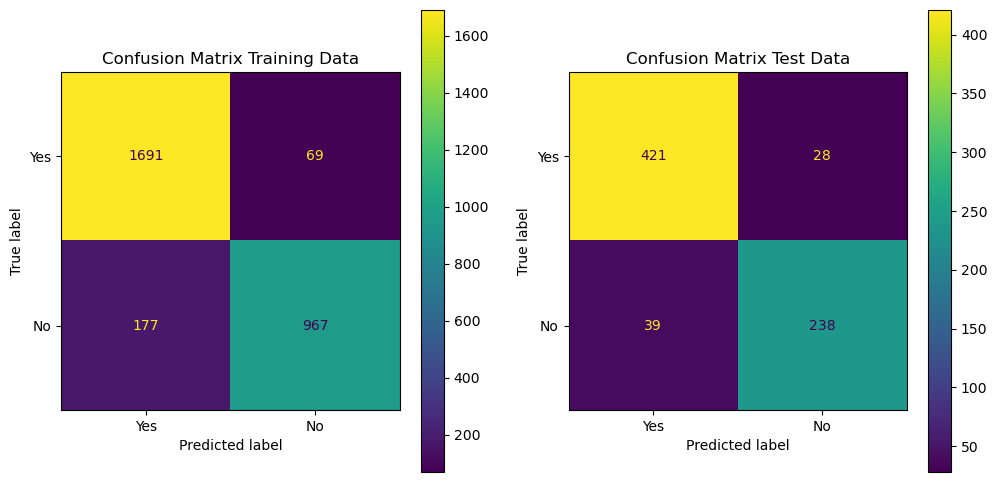

In [61]:
# Now let's evaluate it:
y_pred_train = lr.predict(X_train_sc)
y_pred_test = lr.predict(X_test_sc)

# We can view the overall accuracy score of this Logistic Regression model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("Logistic Regression Accuracy on Training Data: ", round(acc_train, 3))
print("Logistic Regression Accuracy on Test Data: ", round(acc_test, 3))


# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix
lr_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=lr_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

lr_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=lr_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')

plt.show()

prec_train = precision_score(y_train, y_pred_train)
prec_test = precision_score(y_test, y_pred_test)

#store metrics for this model
results.append(["Logistic Regression", lr_model_time, acc_train, acc_test, prec_train, prec_test])

In [63]:
# Coefficients from Linear regression
coefficients_lr = lr.coef_[0]
coefficients_lr_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coefficients_lr})
coefficients_lr_df = coefficients_lr_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Linear Regression:")
print(coefficients_lr_df)


Coefficients from Linear Regression:
                                           feature  coefficient
28             Curricular units 2nd sem (approved)     2.980542
22             Curricular units 1st sem (approved)     1.904812
14                         Tuition fees up to date     0.945750
18                                   International     0.864438
16                              Scholarship holder     0.364358
29                Curricular units 2nd sem (grade)     0.362011
30  Curricular units 2nd sem (without evaluations)     0.283741
9                              Mother's occupation     0.189484
5                           Previous qualification     0.144696
0                                   Marital status     0.144056
8                           Father's qualification     0.084646
21          Curricular units 1st sem (evaluations)     0.075341
10                             Father's occupation     0.053344
24  Curricular units 1st sem (without evaluations)     0.016743
32

**Basic KNN Model**

The KNN model took  0.004
KNN Accuracy on Training Data:  0.897
KNN Accuracy on Test Data:  0.853


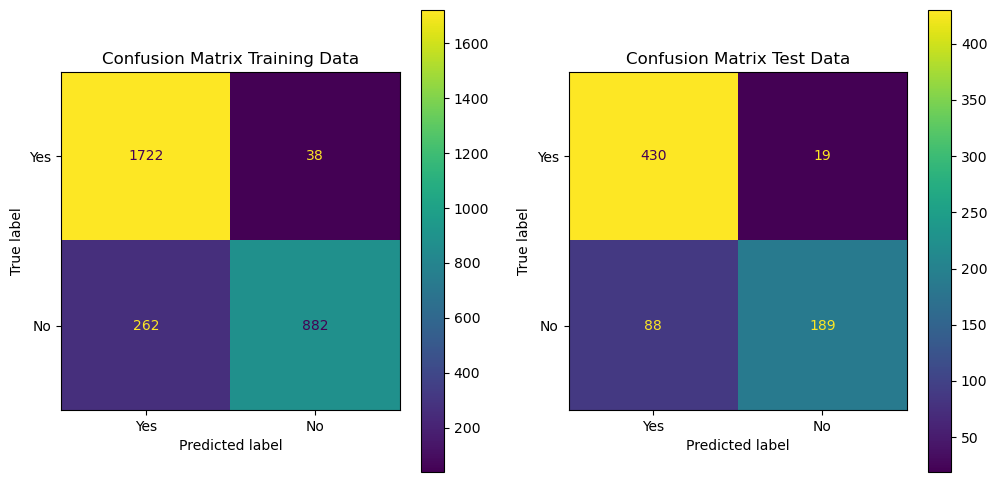

In [65]:
# Basic KNN model
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
end_time = time.time()
knn_model_time = end_time - start_time

print("The KNN model took ", round(knn_model_time, 4))

# Now let's evaluate it:
y_pred_train = knn.predict(X_train_sc)
y_pred_test = knn.predict(X_test_sc)

# We can view the overall accuracy score of this KNN model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("KNN Accuracy on Training Data: ", round(acc_train, 3))
print("KNN Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix
knn_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=knn_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

knn_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=knn_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

prec_train = precision_score(y_train, y_pred_train)
prec_test = precision_score(y_test, y_pred_test)

#store metrics for this model
results.append(["KNN", knn_model_time, acc_train, acc_test, prec_train, prec_test])

**Basic Decision Tree Model**

The Decision Tree model took  0.0356
Decision Tree Accuracy on Training Data:  1.0
Decision Tree Accuracy on Test Data:  0.84


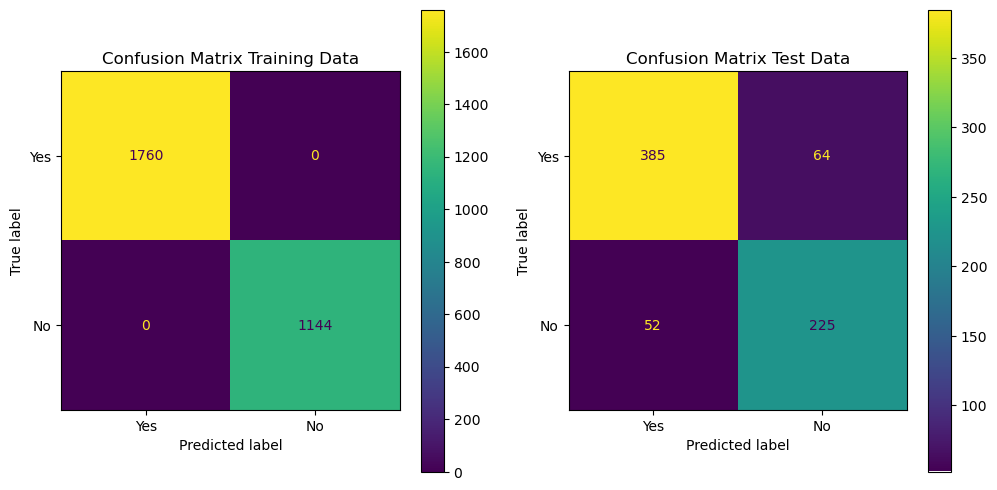

In [67]:
# Basic DecisionTree model
# Note that unlike the other models, we can use un-scaled data for Decision Trees
start_time = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
end_time = time.time()
dt_model_time = end_time - start_time

print("The Decision Tree model took ", round(dt_model_time, 4))

# Now let's evaluate it:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

# We can view the overall accuracy score of this Decision Tree model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("Decision Tree Accuracy on Training Data: ", round(acc_train, 3))
print("Decision Tree Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
dt_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=dt_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

dt_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=dt_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

prec_train = precision_score(y_train, y_pred_train)
prec_test = precision_score(y_test, y_pred_test)

#store metrics for this model
results.append(["Decision Tree", dt_model_time, acc_train, acc_test, prec_train, prec_test])

I think this model without some constraints is definitely overfitting!
The accuracy on the training data is 1 but its only 0.86 on the test data.  
Given all of the columns available I think I need to add some constraints to this model to control the overfitting

In [69]:
# Feature importance from Decision Tree
fimportance_tree = dt.feature_importances_
feature_importance_tree_df = pd.DataFrame({'feature': X_train.columns, 'importance': fimportance_tree})
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree:")
print(feature_importance_tree_df)


Feature Importance from Decision Tree:
                                           feature  importance
28             Curricular units 2nd sem (approved)    0.554236
14                         Tuition fees up to date    0.070797
26             Curricular units 2nd sem (enrolled)    0.036926
29                Curricular units 2nd sem (grade)    0.033451
23                Curricular units 1st sem (grade)    0.026633
27          Curricular units 2nd sem (evaluations)    0.021848
31                               Unemployment rate    0.021426
7                           Mother's qualification    0.020575
10                             Father's occupation    0.018714
8                           Father's qualification    0.017883
9                              Mother's occupation    0.017729
3                                           Course    0.017203
33                                             GDP    0.016217
17                               Age at enrollment    0.016170
22             

**Basic SVM (Linear) model**

The SVM model took  0.1037
SVM Accuracy on Training Data:  0.934
SVM Accuracy on Test Data:  0.899


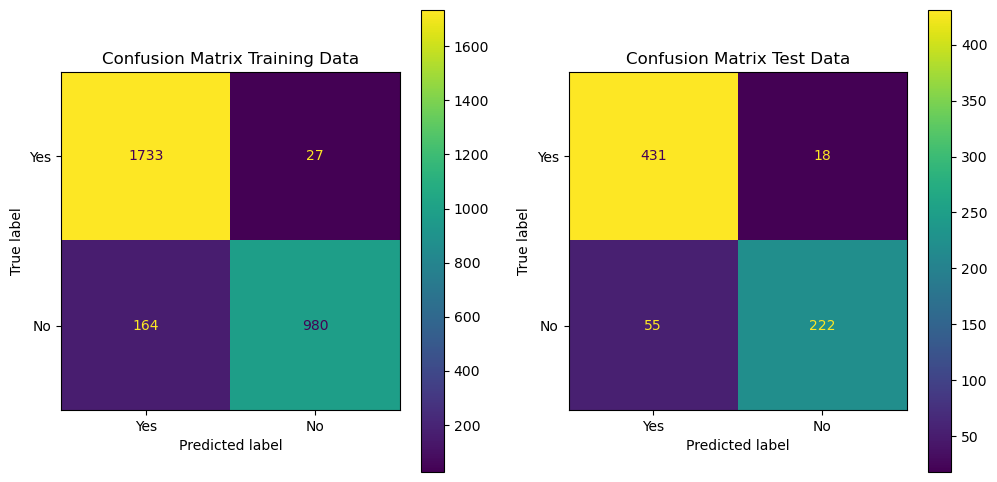

In [71]:
# Basic SVM model
start_time = time.time()
svm = SVC()
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time

print("The SVM model took ", round(svm_model_time, 4))

# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("SVM Accuracy on Training Data: ", round(acc_train, 3))
print("SVM Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
svm_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=svm_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

svm_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=svm_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

prec_train = precision_score(y_train, y_pred_train)
prec_test = precision_score(y_test, y_pred_test)

#store metrics for this model
results.append(["SVM", svm_model_time, acc_train, acc_test, prec_train, prec_test])

**Results of Initial Models**

In [73]:
# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['model', 'model time', 'train accuracy', 'test accuracy', 'train precision', 'test precision'])
results_df

,model,model time,train accuracy,test accuracy,train precision,test precision
0,baseline,0.001625,0.606061,0.618457,0.606061,0.618457
1,Logistic Regression,0.039706,0.915289,0.907713,0.905246,0.915217
2,KNN,0.003995,0.896694,0.852617,0.867944,0.830116
3,Decision Tree,0.035556,1.000000,0.840220,1.000000,0.881007
4,SVM,0.103698,0.934229,0.899449,0.913548,0.886831


Comparing the classification models with default settings shown above, Logistic Regression appears to have done the best on the test data, both when looking at accuracy scores and precision scores. 
And KNN seems to be the weakest model (other than the baseline "Dummy" model).

**Improving the Models**

In [75]:
# Let's use GridSearchCV to try different options for these models
# I've removed SVM from this list because it was too slow to incorporate in the GridSearchCV - it needs more time/computing power.

models = {
    'KNN': (KNeighborsClassifier(), {'KNN__n_neighbors': [3, 5, 7]}),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {'LogisticRegression__C': [0.01, 0.1, 1, 10]}),
    'DecisionTree': (DecisionTreeClassifier(), {'DecisionTree__max_depth': [5, 10, 15, 20, 25, 30]}),
    'SVM': (SVC(), {'SVM__kernel': ['linear', 'rbf'], 'SVM__C': [0.1, 1, 10]})
}

gs_results = []

for name, (model, params) in models.items():
    
    # Create a pipeline
    pipeline = Pipeline([
        (name, model)
    ])

    print(name)
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring = 'accuracy')
    
    # Fit the model and time it
    start_time = time.time()
    if name == 'DecisionTree':
        grid_search.fit(X_train, y_train)
    else:
        grid_search.fit(X_train_sc, y_train)        
    model_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Predict using the best model
    if name == 'DecisionTree':
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
    else: 
        y_pred_train = best_model.predict(X_train_sc)
        y_pred_test = best_model.predict(X_test_sc)
       
    
    # Evaluate on training and test sets
    if name == 'DecisionTree':
        acc_train_score = best_model.score(X_train, y_train)
        acc_test_score = best_model.score(X_test, y_test)
    else:
        acc_train_score = best_model.score(X_train_sc, y_train)
        acc_test_score = best_model.score(X_test_sc, y_test)
    
    prec_train = precision_score(y_train, y_pred_train)
    prec_test = precision_score(y_test, y_pred_test)
    
    # Append the results
    gs_results.append([name, best_model, model_time, acc_train_score, acc_test_score, prec_train, prec_test])




KNN
LogisticRegression
DecisionTree
SVM


**GridSearchCV Results**

In [77]:
# Create the results DataFrame
gs_results_df = pd.DataFrame(gs_results, columns=['model', 'optimal model', 'model time', 'train accuracy', 'test accuracy', 'train precision', 'test precision'])
gs_results_df

,model,optimal model,model time,train accuracy,test accuracy,train precision,test precision
0,KNN,(KNeighborsClassifier(n_neighbors=7)),0.688622,0.883264,0.859504,0.849140,0.830476
1,LogisticRegression,"(LogisticRegression(C=1, max_iter=1000))",0.019972,0.915289,0.907713,0.905246,0.915217
2,DecisionTree,(DecisionTreeClassifier(max_depth=5)),0.039987,0.912879,0.888430,0.896788,0.880165
3,SVM,"(SVC(C=0.1, kernel='linear'))",0.158373,0.915634,0.911846,0.895561,0.895277
